In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

#from statsforecast import StatsForecast

In [58]:
df = pd.read_csv("train.csv")
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [59]:
df.shape

(79023, 76)

In [60]:
# Unique values of latitudes and longitudes
print("latitudes:", len(set(df["latitude"])), "longitudes:", len(set(df["longitude"])))

latitudes: 452 longitudes: 453


In [61]:
# Checking the number of unique locations in the data set
unique_latlongs = df.drop_duplicates(subset = ["latitude", "longitude"])
print(unique_latlongs.iloc[:, :4])

print("Total rows of data=", len(unique_latlongs) * 159)

           ID_LAT_LON_YEAR_WEEK  latitude  longitude  year
0      ID_-0.510_29.290_2019_00    -0.510     29.290  2019
159    ID_-0.528_29.472_2019_00    -0.528     29.472  2019
318    ID_-0.547_29.653_2019_00    -0.547     29.653  2019
477    ID_-0.569_30.031_2019_00    -0.569     30.031  2019
636    ID_-0.598_29.102_2019_00    -0.598     29.102  2019
...                         ...       ...        ...   ...
78228  ID_-3.153_30.347_2019_00    -3.153     30.347  2019
78387  ID_-3.161_28.839_2019_00    -3.161     28.839  2019
78546  ID_-3.174_29.926_2019_00    -3.174     29.926  2019
78705  ID_-3.287_29.713_2019_00    -3.287     29.713  2019
78864  ID_-3.299_30.301_2019_00    -3.299     30.301  2019

[497 rows x 4 columns]
Total rows of data= 79023


In [62]:
# Make a location column in this form: "latitude_longitude"
df["location_id"] = df["latitude"].astype(str) + '  ' + df["longitude"].astype(str)

In [7]:
# Missing values per column
na_counts = df.isna().sum()
for index, count in na_counts.items():
    print(index, count)

ID_LAT_LON_YEAR_WEEK 0
latitude 0
longitude 0
year 0
week_no 0
SulphurDioxide_SO2_column_number_density 14609
SulphurDioxide_SO2_column_number_density_amf 14609
SulphurDioxide_SO2_slant_column_number_density 14609
SulphurDioxide_cloud_fraction 14609
SulphurDioxide_sensor_azimuth_angle 14609
SulphurDioxide_sensor_zenith_angle 14609
SulphurDioxide_solar_azimuth_angle 14609
SulphurDioxide_solar_zenith_angle 14609
SulphurDioxide_SO2_column_number_density_15km 14609
CarbonMonoxide_CO_column_number_density 2122
CarbonMonoxide_H2O_column_number_density 2122
CarbonMonoxide_cloud_height 2122
CarbonMonoxide_sensor_altitude 2122
CarbonMonoxide_sensor_azimuth_angle 2122
CarbonMonoxide_sensor_zenith_angle 2122
CarbonMonoxide_solar_azimuth_angle 2122
CarbonMonoxide_solar_zenith_angle 2122
NitrogenDioxide_NO2_column_number_density 18320
NitrogenDioxide_tropospheric_NO2_column_number_density 18320
NitrogenDioxide_stratospheric_NO2_column_number_density 18320
NitrogenDioxide_NO2_slant_column_number_den

#### Emissions EDA

In [20]:
print("Range of emission values")
print("Emission min:", df["emission"].min())
print("Emission max:", df["emission"].max())

Range of emission values
Emission min: 0.0
Emission max: 3167.768


In [47]:
df["emission"].describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

In [64]:
# High emission indices
high_emissions_df = df.loc[df["emission"] > 2000]
high_emissions_df.head(60)

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,location_id
46587,ID_-2.079_29.321_2019_00,-2.079,29.321,2019,0,NaN,NaN,NaN,NaN,NaN,...,68139.833964,1856.415641,32.131939,0.239269,-41.171539,29.888111,-133.322392,31.588696,2778.1920,-2.079 29.321
46588,ID_-2.079_29.321_2019_01,-2.079,29.321,2019,1,NaN,NaN,NaN,NaN,NaN,...,58517.607479,2926.521405,34.762639,0.253798,44.984207,40.190883,-143.739903,25.914405,2950.9507,-2.079 29.321
46589,ID_-2.079_29.321_2019_02,-2.079,29.321,2019,2,0.000159,0.741044,0.000118,0.077346,-98.683156,...,53755.163592,3443.213782,19.929754,0.261905,15.449158,30.402736,-140.554126,25.307976,3093.1740,-2.079 29.321
46590,ID_-2.079_29.321_2019_03,-2.079,29.321,2019,3,0.000322,0.682432,0.000215,0.168179,-13.240126,...,47789.731655,4831.351318,15.753355,0.265051,-12.708137,37.690640,-135.281579,26.302885,3136.0488,-2.079 29.321
46591,ID_-2.079_29.321_2019_04,-2.079,29.321,2019,4,0.000042,0.779578,0.000029,0.106102,15.632729,...,55349.706102,3230.417142,8.344532,0.261588,73.571106,46.080676,-142.490367,19.759141,3131.8489,-2.079 29.321
46592,ID_-2.079_29.321_2019_05,-2.079,29.321,2019,5,-0.000024,0.722607,-0.000021,0.122191,-55.443980,...,50528.287051,4074.340447,10.763899,0.269940,30.211407,36.954013,-134.640866,20.354112,3167.7680,-2.079 29.321
46593,ID_-2.079_29.321_2019_06,-2.079,29.321,2019,6,-0.000077,0.763165,-0.000057,0.045423,15.816516,...,47514.268354,4638.462923,26.505841,0.264941,-11.956453,28.159291,-120.792826,23.785329,3112.7644,-2.079 29.321
46594,ID_-2.079_29.321_2019_07,-2.079,29.321,2019,7,-0.000145,0.767676,-0.000111,0.298395,73.658966,...,46688.400745,4643.222299,21.132313,0.242241,5.613165,26.322330,-115.202476,21.829456,3128.4414,-2.079 29.321
46595,ID_-2.079_29.321_2019_08,-2.079,29.321,2019,8,0.000075,0.721732,0.000059,0.141324,-70.213324,...,59614.651459,2666.412027,22.817905,0.274204,-49.855416,37.956675,-109.660632,23.083674,3136.6560,-2.079 29.321
46640,ID_-2.079_29.321_2020_00,-2.079,29.321,2020,0,-0.000019,0.901467,-0.000015,0.135616,-100.677452,...,63949.449714,3927.710586,8.980786,0.273905,-42.021438,27.264902,-135.228995,30.755242,2710.7104,-2.079 29.321


In [24]:
# Emission max index
df.loc[df["emission"] == df["emission"].max()]

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
46592,ID_-2.079_29.321_2019_05,-2.079,29.321,2019,5,-0.000024,0.722607,-0.000021,0.122191,-55.44398,...,5130.179853,50528.287051,4074.340447,10.763899,0.26994,30.211407,36.954013,-134.640866,20.354112,3167.768


In [65]:
# Emission min indices
min_emissions_df = df.loc[df["emission"] == df["emission"].min()]
min_emissions_df["year"].value_counts()

year
2019    795
2020    795
2021    795
Name: count, dtype: int64

In [66]:
min_emissions_df["location_id"].value_counts()

location_id
-1.328  28.872    159
-1.505  30.995    159
-1.532  28.568    159
-1.682  29.218    159
-1.696  28.304    159
-1.712  28.688    159
-1.73  28.47      159
-1.833  28.467    159
-1.839  28.761    159
-1.974  28.526    159
-2.496  28.504    159
-2.817  29.283    159
-2.841  29.159    159
-2.859  29.041    159
-2.898  29.002    159
Name: count, dtype: int64

#### There are 15 locations where carbon emission is 0 for all 53 weeks in each year: 2019, 2020, 2021. 

In [ ]:
# I need to plot emissions to look for seasonality and trend. But how to do that with two dimensional data?
# plt.plot(df["emission"])

<Axes: xlabel='week_no', ylabel='emission'>

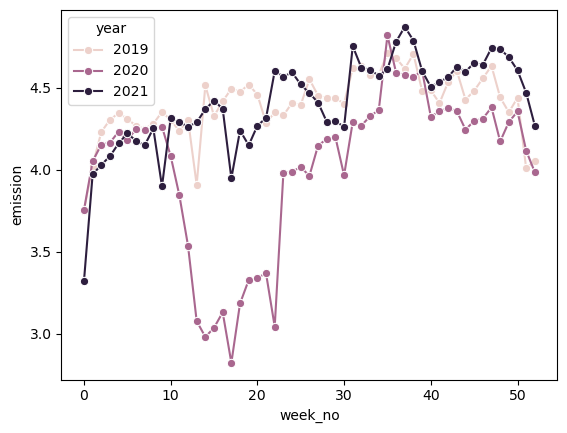

In [81]:
# Approach 1: Plotting emissions by location (will need to make 497 plots)
small_df = df.head(159)
sns.lineplot(data = small_df, x = "week_no", y = "emission", hue = "year", marker="o")

,year,week_no
0,2019,0
1,2019,1
2,2019,2
3,2019,3
4,2019,4


497.0

0    2019
1    2019
2    2019
3    2019
4    2019
Name: year, dtype: int64

#### How to handle missing values (in context of problem and in context of time series data)?